In [1]:
import scipy.io
anno_box = scipy.io.loadmat('/home/yuxuan/gpnn/tmp/hico/hico_20160224_det/anno_bbox.mat')

In [2]:
#anno_box is a dictionary of hico_detect dataset
print(anno_box.keys())
#keys are "bbox_train","bbox_test","list_action","__header__","__globals__","__version__"

print(anno_box["bbox_train"].shape)
# totally 38118 training images
print(anno_box["bbox_test"].shape)
# totally 9615 test images

print(anno_box["list_action"].shape)
# contains objects and actions

['__header__', 'list_action', '__globals__', 'bbox_train', 'bbox_test', '__version__']
(1, 38118)
(1, 9658)
(600, 1)


In [3]:
import numpy as np

bbox_train = anno_box['bbox_train']

def collect_hoi_stats(bbox):
    stats = np.zeros(600)
    for idx in range(bbox['filename'].shape[1]):
        for i_hoi in range(bbox['hoi'][0, idx]['id'].shape[1]):
            hoi_id = bbox['hoi'][0, idx]['id'][0, i_hoi][0, 0]
            stats[int(hoi_id)-1] += 1

    return stats

# return appearence of each hoi in datasets, try to find rare hoi
stats = collect_hoi_stats(bbox_train) 

### anno_box
<p align="center"><img width="40%" src="tmp/img/Screenshot from 2020-12-06 11-53-46.png"></p> 

### hoi
#### corresponding hoi action Id, bounding box information
<p align="center"><img width="25%" src="tmp/img/Screenshot from 2020-12-06 12-00-20.png"></p> 

### action Id
#### filtered by object, and denotes which action interacted on the object
<p align="center"><img width="50%" src="tmp/img/Screenshot from 2020-12-06 12-18-54.png"></p> 

### bboxhuman: 
#### bounding box points for human in image
<p align="center"><img width="30%" src="tmp/img/Screenshot from 2020-12-06 12-01-28.png"></p> 

### bboxobject
#### bounding box points for object in image
<p align="center"><img width="20%" src="tmp/img/Screenshot from 2020-12-06 12-01-48.png"></p> 

### original image
<p align="center"><img width="40%" src="tmp/img/HICO_test2015_00000001.jpg"></p> 

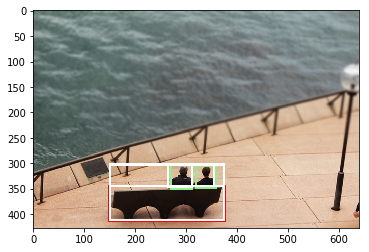

In [14]:
# visualize the hico dataset: use HICO_test2015_00000001.jpg

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

im = np.array(Image.open('tmp/img/HICO_test2015_00000001.jpg'), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch, whose white box corresponds to .p file
rect_obj = patches.Rectangle((148,345),376-148,414-345,linewidth=2,edgecolor='r',facecolor='none')
rect_h1 = patches.Rectangle((320,306),359-320,349-306,linewidth=2,edgecolor='lightgreen',facecolor='none')
rect_h2 = patches.Rectangle((270,303),311-270,350-303,linewidth=2,edgecolor='lightgreen',facecolor='none')

rect_obj_extracted = patches.Rectangle((150,344),374-150,412-344,linewidth=2,edgecolor='white',facecolor='none')
rect_h1_extracted = patches.Rectangle((265,302),312-265,347-302,linewidth=2,edgecolor='white',facecolor='none')
rect_h2_extracted = patches.Rectangle((312,303),354-312,344-303,linewidth=2,edgecolor='white',facecolor='none')
rect_concat_h1_obj = patches.Rectangle((150,303),374-150,412-303,linewidth=2,edgecolor='white',facecolor='none')
rect_concat_h2_obj = patches.Rectangle((150,302),374-150,412-302,linewidth=2,edgecolor='white',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect_obj)           # ground truth bounding box
ax.add_patch(rect_h1)
ax.add_patch(rect_h2)

ax.add_patch(rect_obj_extracted) # extracted object: coach
ax.add_patch(rect_h1_extracted)  # extracted human 1
ax.add_patch(rect_h2_extracted)  # extracted human 2
ax.add_patch(rect_concat_h1_obj) # concatenated box: human1 + object
ax.add_patch(rect_concat_h2_obj) # concatenated box: human2 + object

plt.show()

In [22]:
import pickle
import numpy as np

# /tmp/hico/processed/hico_data_background_49/ is saving path, which should be used for the GPNN
# saved feature: edge and node in .npy, other information like boxes and classes are in .p
data = pickle.load(open( "/home/yuxuan/gpnn/tmp/hico/processed/hico_data_background_49/HICO_train2015_00000004.p", "rb" ))
edge_features = np.load("/home/yuxuan/gpnn/tmp/hico/processed/hico_data_background_49/HICO_train2015_00000004_edge_features.npy")
node_features = np.load("/home/yuxuan/gpnn/tmp/hico/processed/hico_data_background_49/HICO_train2015_00000004_node_features.npy")

In [25]:
# features extraction
# finetune.py
import feature_extraction.metadata as metadata
import feature_extraction.roi_feature_model as roi_feature_model
import torch.utils.data
import torch.autograd
import torch
import torchvision
import os
import shutil
import argparse
import time

feature_type = 'resnet'
input_h, input_w = 224, 224 # Image should be resized

hico_path = "/home/yuxuan/gpnn/tmp/hico"

# path to save the features (used to compute the input of GPNN)
feature_path = os.path.join(hico_path, 'processed', 'features_background_49')
if not os.path.exists(feature_path):
    os.makedirs(feature_path)
        
image_list = list()     
image_list_file = os.path.join(hico_path, 'trainval.txt')
with open(image_list_file) as f:
    for line in f.readlines():
        image_list.append(line.strip())
        
# build resnet-152 model for feature extraction
feature_network = roi_feature_model.Resnet152(num_classes=len(metadata.action_classes))
feature_network = torch.nn.DataParallel(feature_network).cuda()
# should load the best model, which is tuned in the fine_tune.py

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),])


# Read detection results
det_res_path = os.path.join(hico_path, 'hico_detect_trainvaltest_detections.pkl')
with open(det_res_path, 'r') as f:
    # detection results: [class_num][img_num][detection_num][x1, y1, x2, y2, score]
    det_res = pickle.load(f)
        
# hardcoding of classes        
classes = ['__background__',  # always index 0
               'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
               'traffic_light', 'fire_hydrant', 'stop_sign', 'parking_meter', 'bench', 'bird', 'cat', 'dog', 'horse',
               'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports_ball', 'kite', 'baseball_bat', 'baseball_glove',
               'skateboard', 'surfboard', 'tennis_racket', 'bottle', 'wine_glass', 'cup', 'fork', 'knife', 'spoon',
               'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot_dog', 'pizza', 'donut',
               'cake', 'chair', 'couch', 'potted_plant', 'bed', 'dining_table', 'toilet', 'tv', 'laptop', 'mouse',
               'remote', 'keyboard', 'cell_phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
               'clock', 'vase', 'scissors', 'teddy_bear', 'hair_drier', 'toothbrush']

In [77]:
# roi extract features

import feature_extraction.extract_roi_features as extract_roi_features

total_idx = 0
skip_idx = 0
used_img_list = list()
for i_image, img_name in enumerate(image_list):
    print(img_name)
    total_idx += 1
    # Extracted bounding boxes and classes
    det_boxes_all = np.empty((0, 4))
    det_classes_all = list()
    for c in range(1, len(classes)): # except position 0 because it is "__background__"
        for detection in det_res[c][i_image]:
            if detection[4] > 0.7:
                det_boxes_all = np.vstack((det_boxes_all, np.array(detection[:4])[np.newaxis, ...]))
                det_classes_all.append(c)
    if len(det_classes_all) == 0: # image action not in the classes
        print(' skipping')
        skip_idx += 1
        continue
        
    used_img_list.append(img_name + '\n')
    
    edge_classes = list()
    
    for person_i, person_c in enumerate(det_classes_all):
        if person_c == 1:
            for obj_i, obj_c in enumerate(det_classes_all):
                if obj_c == 1:
                    continue
                combined_box = extract_roi_features.combine_box(det_boxes_all[person_i, :], det_boxes_all[obj_i, :])
                det_boxes_all = np.vstack((det_boxes_all, combined_box))
                edge_classes.append(0)
    det_classes_all.extend(edge_classes)

    # Get image feature by applying VGG to ROI (roi_vgg)
    image_path = os.path.join(hico_path, 'hico_20160224_det', "images",'train2015',img_name + '.jpg')
    assert os.path.exists(image_path)
    original_img = scipy.misc.imread(image_path, mode='RGB')

    roi_features = np.zeros((det_boxes_all.shape[0], 1000))
                        

    for i_box in range(det_boxes_all.shape[0]):
        roi = det_boxes_all[i_box, :].astype(int)
        roi_image = original_img[roi[1]:roi[3]+1, roi[0]:roi[2]+1, :]
        # plt.imshow(roi_image)
        # plt.show()
        roi_image = transform(cv2.resize(roi_image, (input_h, input_w), interpolation=cv2.INTER_LINEAR))
        roi_image = torch.autograd.Variable(roi_image.unsqueeze(0)).cuda()
        feature, _ = feature_network(roi_image)
        roi_features[i_box, ...] = feature.data.cpu().numpy()

    np.save(os.path.join(feature_path, '{}_classes'.format(img_name)), det_classes_all)
    np.save(os.path.join(feature_path, '{}_boxes'.format(img_name)), det_boxes_all)
    np.save(os.path.join(feature_path, '{}_features'.format(img_name)), roi_features)
                            

HICO_train2015_00000001


/home/yuxuan/anaconda3/envs/gpnn/lib/python2.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


ValueError: could not broadcast input array from shape (200) into shape (1000)

In [12]:
import scipy.io
anno_bbox = scipy.io.loadmat('/home/yuxuan/gpnn/tmp/hico/hico_20160224_det/anno_bbox.mat')
anno = scipy.io.loadmat('/home/yuxuan/gpnn/tmp/hico/hico_20160224_det/anno.mat')

In [14]:
num_hoi = anno['list_action'].shape[0]
hoi_list = [None]*num_hoi

for i in range(num_hoi):
    hoi_list[i] = {
        'id': str(i+1).zfill(3),
        'object': anno['list_action'][i,0][0][0],
        'verb': anno['list_action'][i,0][1][0],
    }
    
num_hois = anno_bbox['bbox_{subset}'][0,i][2].shape[1]
hois = [None]*num_hois
for j in range(num_hois):
    hoi_data = anno_bbox['bbox_{subset}'][0,i][2][0,j]

    hoi_id = str(hoi_data[0][0,0]).zfill(3)    

    num_boxes = hoi_data[1].shape[1]
    human_bboxes = [None]*num_boxes
    for b in range(num_boxes):
        human_bboxes[b] = \
            [int(hoi_data[1][0,b][k][0,0]-1) for k in [0,2,1,3]]

    num_boxes = hoi_data[2].shape[1]
    object_bboxes = [None]*num_boxes
    for b in range(num_boxes):
        object_bboxes[b] = \
            [int(hoi_data[2][0,b][k][0,0]-1) for k in [0,2,1,3]]

    connections = (hoi_data[3]-1).tolist()

    invis = int(hoi_data[4][0,0])

    hois[j] = {
        'id': hoi_id,
        'human_bboxes': human_bboxes,
        'object_bboxes': object_bboxes,
        'connections': connections,
        'invis': invis,
    }

SyntaxError: invalid syntax (<ipython-input-14-d8f953a11749>, line 11)